<a href="https://colab.research.google.com/github/benf549/CARPdock/blob/main/run_CARPdock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook walks you through generating a starting point for the NISE protocol using CARPdock, LASErMPNN, and Boltz-2

CARPdock is a random rigid-rigid docking search of ligand placements inside defined backbone structures. The backbones used in this notebook (4-Helix Bundles and NTF2 Folds) have already been 'derisked' for small molecule binding and empirically through our computational and experimental testing, CARPdock likely improves design success rates over <i>de novo</i> scaffold generation with methods like RFDiffusion, BoltzDesign, ProteinHunter, BoltzGen, etc... when combined with the NISE protocol since we can optimize the initial bad backbone + ligand pose into very high AlphaFold confidence while staying close to the initial 'derisked' protein fold.

![Outputs of the CARPdock protocol on a single backbone, many rigid ligand poses placed in a single protein scaffold](https://raw.githubusercontent.com/benf549/CARPdock/main/images/example_carp_output.png)


The default settings of this notebook reduce the rigor of the CARPdock search process from what we have experimentally validated to ensure the notebook runs completely in around 15 minutes. Please check the parameters we have used on GitHub to maximize your success probability.


Check out the code blocks for comments which might switch the notebook to generate more rigorous designs at the expense of computational complexity.

## 0) Install LASErMPNN & Boltz-2 for NISE protocol (Hit `Run all` -> Notebook will automatically 'crash' and restart, this is expected -> Hit `Run all` again after restart)

In [1]:
# @title
try:
  import torch
  import torch_scatter
  import torch_cluster

  if torch.__version__ != '2.8.0+cu126':
    raise ValueError

  import pykeops
  pykeops.test_numpy_bindings()
  pykeops.test_torch_bindings()

  print('Dependencies installed successfully! Installing LASErMPNN.')
  !git clone https://github.com/polizzilab/LASErMPNN.git --depth 1
  !git clone https://github.com/polizzilab/NISE.git --depth 1
  !git clone https://github.com/benf549/CARPdock.git --depth 1
  !git clone https://gist.github.com/5df64c1b2ee6364902e1d614a037effe.git
  !mv /content/5df64c1b2ee6364902e1d614a037effe/calc_symmetry_aware_rmsd.py /content/

except:
  !uv pip install --system "torch==2.8.0" scipy 'numpy<2.0.0' pandas scikit-learn h5py pytest prody matplotlib seaborn jupyter plotly pykeops logomaker wandb tqdm rdkit py3Dmol openbabel-wheel 'boltz[cuda]==2.2.1' freesasa
  !pip install torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

  import os
  os.kill(os.getpid(), 9)

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 1) of formula Sum((a-b)**2) with a=Var(0,3,0), b=Var(1,3,1) ... OK
pyKeOps with numpy bindings is working!
pyKeOps with torch bindings is working!
Dependencies installed successfully! Installing LASErMPNN.
Cloning into 'LASErMPNN'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 52 (delta 4), reused 40 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 156.68 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (44/44), done.
Cloning into 'NISE'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 1), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% 

In [2]:
import sys
import logging
import numpy as np
import prody as pr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from pathlib import Path

pr.confProDy(verbosity='none')
logging.basicConfig(level=logging.DEBUG, filename='app.log', force=True)
logging.getLogger("prody").setLevel(logging.WARNING)

/usr/local/lib/python3.12/dist-packages/prody/atomic/flags.py:532: SyntaxWarning: invalid escape sequence '\ '
  \                            *PDB*  *Source*  *Conflict*
/usr/local/lib/python3.12/dist-packages/prody/atomic/select.py:203: SyntaxWarning: invalid escape sequence '\|'
  **Special characters** (``~!@#$%^&*()-_=+[{}]\|;:,<>./?()'"``) must be
/usr/local/lib/python3.12/dist-packages/prody/atomic/select.py:758: SyntaxWarning: invalid escape sequence '\ '
  RE_NRANGE = re_compile(_ + '\ *(to|:)\ *' + _)
/usr/local/lib/python3.12/dist-packages/prody/sequence/analysis.py:174: SyntaxWarning: invalid escape sequence '\{'
  * ``'minent'``: :math:`min\{H(X), H(Y)\}`, minimum entropy
/usr/local/lib/python3.12/dist-packages/prody/proteins/dssp.py:87: SyntaxWarning: invalid escape sequence '\*'
  * *dssp_acc*: number of water molecules in contact with this residue \*10.
/usr/local/lib/python3.12/dist-packages/prody/dynamics/pca.py:79: SyntaxWarning: invalid escape sequence '\_'
  treated

## 1) Generate random initial starting points (using CARPdock) for a small-molecule of interest placed inside a library of 40 helical bundle scaffolds without sequences.

To use your own scaffold (protein-backbones without a sequence) library, replace the contents of /content/CARPdock/example_backbones with your own scaffolds containing only N CA C and O atoms. You can generate appropriate scaffolds using these from a protein structure using ProDy with the following snippet:

```python
import prody as pr
protein = pr.parsePDB('path_to_starting_protein.pdb')
backbone_only = protein.select('name N CA C O').copy()
pr.writePDB('backbone_only.pdb', backbone_only)
```

In [3]:
# @title ### Enter SMILES-string representation of your target ligand.

# @markdown An example SMILES string for [Exatecan](https://pubchem.ncbi.nlm.nih.gov/compound/151115) is: `CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=C5[C@H](CCC6=C5C(=CC(=C6C)F)N=C4C3=C2)N)O`

# @markdown To find a SMILES string representation of your ligand, you can search for your ligand on https://pubchem.ncbi.nlm.nih.gov/

# @markdown **Ensure the SMILES string should encodes the stereochemistry of your target ligand and that it encodes the appropriate protonation state.**

# @markdown <u> The Exatecan SMILES string example above is in the wrong (neutral) protonation state</u>. It should have a formal charge of +1 on the tertiary amine.

# @markdown You can use `OpenBabel` to predict the correct SMILES string, however this is not 100% reliable. You can use an interactive tool like ChemDraw to manually protonate your ligand if you know what state you want to bind and then copy the output as a SMILES string and uncheck the `update_protonation_with_obabel` flag below.

ligand_smiles = "CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=C5[C@H](CCC6=C5C(=CC(=C6C)F)N=C4C3=C2)N)O" # @param {"type":"string"}
update_protonation_with_obabel = True # @param {"type":"boolean","placeholder":"True"}

import os
import subprocess
from pathlib import Path

import py3Dmol
import prody as pr
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole


# Use OpenBabel to adjust protonation state if necessary.
protonated_smiles = ligand_smiles
if update_protonation_with_obabel:
  input_smiles_file_path = Path('/content/in.smi')
  protonated_smiles_path = Path('/content/out.smi')

  if protonated_smiles_path.exists():
    os.remove(protonated_smiles_path)

  with input_smiles_file_path.open('w') as f:
    f.write(f'{ligand_smiles}\n')

  output = subprocess.run(f'obabel in.smi -p 7.0 -O {protonated_smiles_path}', shell=True, capture_output=True)
  if output.returncode != 0:
    raise ValueError(output.stderr.decode('utf-8'))

  with protonated_smiles_path.open('r') as f:
    protonated_smiles = f.readline().strip()

# Generate a 3D conformer, add protons, write to an pdb/sdf files.
mol = Chem.MolFromSmiles(protonated_smiles)
mol = AllChem.AddHs(mol, addCoords=True)
AllChem.EmbedMolecule(mol)
AllChem.MolToMolFile(mol, 'mol.sdf')
AllChem.MolToPDBFile(mol, 'mol.pdb')

##########
# @markdown #### If you have a reference conformer for your ligand, upload it to the Files tab on the left in sdf format and uncomment below with the path.
# import shutil
# AllChem.MolFromMolFile(PATH_TO_REFERENCE_CONFORMER)
# shutil.copy(PATH_TO_REFERENCE_CONFORMER, 'mol.sdf')
# mol = AllChem.AddHs(mol, addCoords=True)
# AllChem.MolToPDBFile(mol, 'mol.pdb')
##########

# Display protonated molecule.
view = py3Dmol.view()
pdb_str = open('mol.pdb', 'r').read()
view.addModel(pdb_str)
view.addPropertyLabels("atom",{'not':{'elem':'H'}}, {
    'fontColor':'black', 'font': 'sans-serif', 'fontSize': 16, 'showBackground':True, 'backgroundColor':'lightgrey',
    'backgroundOpacity':0.3
})
pdb_str = open('mol.sdf', 'r').read()
view.addModel(pdb_str)
view.setStyle({'stick':{'radius': 0.15}})
view.zoomTo()
view.show()

# @markdown NOTE: This tutorial uses RDKit to generate conformers for the ligand. There are more rigorous ways to do this that are outside the scope of this tutorial (QM/DFT optimization, taking a conformer from a crystal structure in the PDB or Cambridge Structural Database, etc...)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
# @title Run CARPdock
sys.path.append('/content/CARPdock/')
from carp_dock import main as run_carp_dock

ligand_path = Path('/content/mol.pdb')
output_path = Path('/content/carpdock_out/')
output_path.mkdir(exist_ok=True)

# @markdown Select the class of backbone to search ([4-Helix Bundle](https://www.rcsb.org/structure/6W70) or [NTF2 Fold](https://www.rcsb.org/structure/5IF6)). Generally, 4-helix bundles are easier to design and predict structures for so the success rates are higher. NTF2s are more challenging but may be able to accommodate more diverse ligands since they have diverse pocket sizes.
backbone_class = "NTF2 Fold" # @param ["4 Helix Bundle","NTF2 Fold"]

# @markdown Comma-separated list of names of atoms as depicted above to enforce buried inside the protein core. Ex: O3,O1,C1,O2
inside_hull_atoms = "" # @param {"type":"string"}

# @markdown Comma-separated list of names of atoms as depicted above to enforce not buried inside hull defined by protein Ca atoms (typically want to use this for atoms with formal charges or ligand atoms connected to linkers which must be compatible with binding. Ex: N3

# @markdown Generally adding fewer constraints is better and you can always filter for these properties after.
# @markdown <b>Try setting this to the N3 atom (see above) for Exatecan and see how the orientation of the generated poses changes</b>
outside_hull_atoms = "" # @param {"type":"string"}

# @markdown Step size of the 3D grid with which to search the interior of the protein (lower is more rigorous, 0.5 is typical)
test_point_grid_width = 1.0 # @param {"type":"number"}

# @markdown How many ligand rotations to generate when searching for conformations that fit inside the protein structure. 50-100 is typical.
n_ligand_rotations = 25 # @param {"type": "number"}

# @markdown Maximum number of clusters to generate per scaffold after searching pose deduplication. This is how many docks we get per input backbone.
kmeans_clusters_per_scaffold = 20 # @param {"type": "number"}


# @markdown Defines what atoms are buried or not, 9.0 is typical for helical bundles and NTF2s but may need to be tweaked for different folds. See CARPdock GitHub for an explanation.
alpha_hull_alpha = 9.0 # @param {"type": "number"}

# @markdown To save time, limit search to less than the 40 possible backbones.
number_of_backbones_to_screen = "5" # @param ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31","32","33","34","35","36","37","38","39","40"] {"type":"raw"}

constraints = {
    'inside_hull': inside_hull_atoms.split(','),
    'outside_hull': outside_hull_atoms.split(',')
}

backbone_set = {
    '4 Helix Bundle': '/content/CARPdock/example_backbones/',
    'NTF2 Fold': '/content/CARPdock/example_backbones_ntf2/'
}


for idx, backbone in enumerate(sorted(list(Path(backbone_set[backbone_class]).glob('*.pdb')))):
    if idx > int(number_of_backbones_to_screen) - 1:
      break
    print(backbone)
    subdir = output_path / backbone.stem
    if subdir.exists() and len(list(subdir.glob('*.pdb'))) > 0:
        continue
    subdir.mkdir(exist_ok=True)

    run_carp_dock(
        backbone, ligand_path, subdir.absolute(), constraints,
        device='cuda:0', clustering_algorithm='kmeans',
        kmeans_nclusters=kmeans_clusters_per_scaffold,
        test_point_grid_width=test_point_grid_width,
        alpha=alpha_hull_alpha, n_ligand_rotations=n_ligand_rotations,
    )


all_laser_inputs_paths = sorted(list(output_path.glob('*/*.pdb')))
laser_input_path_txt_file = Path("laser_input_paths.txt")
with laser_input_path_txt_file.open("w") as f:
    for path in all_laser_inputs_paths:
        f.write(f"{path.absolute()}\n")

import shutil
with open('laser_input_paths.txt', 'r') as f:
    for line in f.readlines():
        line = Path(line.strip())
        if line.stem.startswith('cluster'):
            shutil.move(line, line.parent / f'{line.parent.stem}-{line.stem}.pdb')

all_laser_inputs_paths = sorted(list(output_path.glob('*/*.pdb')))
laser_input_path_txt_file = Path("laser_input_paths.txt")
with laser_input_path_txt_file.open("w") as f:
    for path in all_laser_inputs_paths:
        f.write(f"{path.absolute()}\n")

/content/CARPdock/example_backbones_ntf2/cluster_00_sup.pdb
Computed 39339 initial test grid points
Filtered to 9102, points


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Found 419 roto-translations satisfying constraints.
Clustered rototranslations into 20 clusters.
Writing outputs to /content/carpdock_out/cluster_00_sup
/content/CARPdock/example_backbones_ntf2/cluster_01_sup.pdb
Computed 33669 initial test grid points
Filtered to 9010, points


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Found 399 roto-translations satisfying constraints.
Clustered rototranslations into 20 clusters.
Writing outputs to /content/carpdock_out/cluster_01_sup
/content/CARPdock/example_backbones_ntf2/cluster_02_sup.pdb
Computed 35235 initial test grid points
Filtered to 9661, points


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Found 1289 roto-translations satisfying constraints.
Clustered rototranslations into 20 clusters.
Writing outputs to /content/carpdock_out/cluster_02_sup
/content/CARPdock/example_backbones_ntf2/cluster_03_sup.pdb
Computed 33669 initial test grid points
Filtered to 8182, points


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

Found 281 roto-translations satisfying constraints.
Clustered rototranslations into 20 clusters.
Writing outputs to /content/carpdock_out/cluster_03_sup


/content/CARPdock/example_backbones_ntf2/cluster_04_sup.pdb
Computed 38367 initial test grid points
Filtered to 9601, points


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


Found 815 roto-translations satisfying constraints.
Clustered rototranslations into 20 clusters.
Writing outputs to /content/carpdock_out/cluster_04_sup


In [5]:
# @title ### Run LASErMPNN on CARPdock outputs
all_poses_paths = sorted(list(Path('/content/carpdock_out/').glob('*/*.pdb')))

with open('laser_input_paths.txt', 'w') as f:
  for path in all_poses_paths:
    f.write(f'{path.absolute()}\n')

# @markdown Cysteine residues are disabled from sampling in LASErMPNN to discourage designs with covalent aggregation issues.
!python -m LASErMPNN.run_batch_inference laser_input_paths.txt lasermpnn_outputs/ 1 --device cuda:0 -n 75 -b 75 --silent --disabled_residues X,C

100% 2/2 [00:37<00:00, 18.83s/it]


In [6]:
%%capture
import freesasa
from calc_symmetry_aware_rmsd import _main as calc_rmsd

# @title ### Run Boltz-2 on LASErMPNN outputs.
all_sequences = []
for path in Path('/content/lasermpnn_outputs/').glob('*/*.pdb'):
  all_sequences.append({
    'laser_path': path.absolute(),
    'sequence': pr.parsePDB(str(path.absolute())).ca.getSequence()
  })

df = pd.DataFrame(all_sequences)

opath = Path('./boltz_inputs_laser_outputs/')
opath.mkdir(exist_ok=True)

for idx, row in df.iterrows():
  with (opath / f'{idx:05d}_laser.fasta').open('w') as f:
    f.write(f'>A|protein|empty\n{row["sequence"]}\n>B|smiles\n{protonated_smiles}')

# @markdown I would suggest opening the code here and replacing the boltz command with the commented out line below if planning to validate designs
# @markdown the Boltz-2x `--use_potentials` flag should help correct ligand stereochemistry issues but it is not perfect.
# @markdown Reimplementing this workflow with RoseTTAFold3 using fixed ligand conformers may be better if Boltz-2x struggles with your ligand even with `--use_potentials`.
# @markdown See the [Boltz GitHub README](https://github.com/jwohlwend/boltz/tree/main) for more information.
# !boltz predict boltz_inputs_laser_outputs --recycling_steps 1 --sampling_steps 200 --use_potentials
!boltz predict boltz_inputs_laser_outputs --recycling_steps 1 --sampling_steps 50

boltz_data = []
for path in Path('./boltz_results_boltz_inputs_laser_outputs/').glob('predictions/*/*.cif'):
  protein = pr.parseMMCIF(str(path))
  sequence = protein.ca.getSequence()
  boltz_data.append({
      'boltz_path': path.absolute(),
      'sequence': sequence,
  })

df_ = pd.DataFrame(boltz_data)
df = df.merge(df_, on='sequence').copy()

rmsd_data = []
for idx, row in df.iterrows():
  protein_rmsd, ligand_rmsd, ligand_plddt = None, None, None
  ligand_solvent_accessible_surface_area = None

  try:
    ref_protein = pr.parsePDB(str(row.laser_path))
    pred_protein = pr.parseMMCIF(str(row.boltz_path))
    protein_rmsd, ligand_rmsd, name_mapping = calc_rmsd(ref_protein, pred_protein, protonated_smiles)
    ligand_plddt = pred_protein.select('chid B ').getBetas().mean()

    opath = row.boltz_path.with_suffix('.pdb')
    pr.writePDB(str(opath.absolute()), pred_protein)
    fsa_struct = freesasa.Structure(str(opath), options={'hetatm':True})
    fsa_result = freesasa.calc(fsa_struct)
    selections = freesasa.selectArea(['ligand, chain B'], fsa_struct, fsa_result)
    ligand_solvent_accessible_surface_area = selections['ligand']

  except Exception as e:
    print(e)
    pass

  rmsd_data.append({
      'protein_ca_rmsd': protein_rmsd, 'laser_path': row.laser_path,
      'ligand_heavy_atom_rmsd': ligand_rmsd, 'ligand_atom_name_mapping': name_mapping,
      'ligand_plddt': ligand_plddt,
      'ligand_solvent_accessible_surface_area': ligand_solvent_accessible_surface_area,
  })

rmsd_df = pd.DataFrame(rmsd_data)
df = df.merge(rmsd_df, on='laser_path').copy()

In [7]:
# @title Inspect the full dataframe.
df

,laser_path,sequence,boltz_path,protein_ca_rmsd,ligand_heavy_atom_rmsd,ligand_atom_name_mapping,ligand_plddt,ligand_solvent_accessible_surface_area
0,/content/lasermpnn_outputs/cluster_01_sup-clus...,MTDEEEVLAWIKEYFEAFNNDDVDKIIELLDPDTKVVLDSGEVLET...,/content/boltz_results_boltz_inputs_laser_outp...,0.618032,8.544380,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",48.825563,66.162117
1,/content/lasermpnn_outputs/cluster_03_sup-clus...,MSDEEKVRKLVKDMVEAFNAGDAEKIRSLFAPDAVMTMSDGSVGTT...,/content/boltz_results_boltz_inputs_laser_outp...,0.586067,8.145329,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",51.367750,87.118661
2,/content/lasermpnn_outputs/cluster_00_sup-clus...,SPIVEEIKKIVKEIYEAGENGDVEKVLSYYADTAVVTGLDNNKTYS...,/content/boltz_results_boltz_inputs_laser_outp...,2.145902,8.164855,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",49.397344,61.082841
3,/content/lasermpnn_outputs/cluster_01_sup-clus...,KSDEQEVRDWLRRFTEAANARDVDAIIELLAPDTKVVLDSGEVLET...,/content/boltz_results_boltz_inputs_laser_outp...,0.756969,1.511487,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",87.702688,30.647136
4,/content/lasermpnn_outputs/cluster_02_sup-clus...,MTEEEKIAAVDEWIERLYSAIENNDLEALESLFDEDTKLYLKNEKK...,/content/boltz_results_boltz_inputs_laser_outp...,0.543815,1.640614,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",47.279125,69.376037
...,...,...,...,...,...,...,...,...
95,/content/lasermpnn_outputs/cluster_00_sup-clus...,SPIVEEIKKLVEEMYKAGDNGDTEAGLSTAADDAVYTDLDINKTYT...,/content/boltz_results_boltz_inputs_laser_outp...,8.843833,10.388652,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",37.864531,138.228441
96,/content/lasermpnn_outputs/cluster_00_sup-clus...,SPIVEEVKKIVKEIYEALDNGDTEKVLSYFADDAVVTGLDTNTTMT...,/content/boltz_results_boltz_inputs_laser_outp...,1.098411,7.622239,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",54.213406,112.128165
97,/content/lasermpnn_outputs/cluster_04_sup-clus...,GAPEDIIAAVSKVITDYFDAINEGDVDKAMSLFHPDATAYVKNLNK...,/content/boltz_results_boltz_inputs_laser_outp...,0.699694,8.011092,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",52.332156,96.531053
98,/content/lasermpnn_outputs/cluster_03_sup-clus...,MSVEAQVTKLVETFYAAGNAGDAATLRSLFAPDAVMTSSDGRVFTT...,/content/boltz_results_boltz_inputs_laser_outp...,0.820073,4.239099,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",61.800719,57.674170


In [8]:
# @title Filter CARPdock poses for self-consistency.

# Select for low protein RMSD, buried ligand (low solvent accessible surface area), and moderately low RMSD to the input
# (if few designs pass the ligand RMSD filter, comment it out since since self-consistency can be optimized later in NISE)
# You can also add additional problem-specific filters here.

df_filtered = df[
    (df.protein_ca_rmsd < 1.5) &  # Select for protien self-consistency to stay close to the input structure.
    (df.ligand_solvent_accessible_surface_area < df.ligand_solvent_accessible_surface_area.quantile(0.25)) & # Enforce that selected pose is in the top quartile most buried.
    (df.ligand_heavy_atom_rmsd < 6.0) # Ligand RMSD Check, not very strict.
].sort_values('ligand_plddt', ascending=False).copy() # Finally, sort by ligand_plddt

if len(df_filtered) == 0:
  raise ValueError("No designs passed filters, adjust the filter criteria in the code block above and rerun the cell or search more exhaustively by adjusting the CARPdock parameters (particularly num_ligand_rotations and number_of_backbones_to_screen).")

print(f'A total of {len(df_filtered)} designs passed self-consistency and burial filters!')
df_filtered

5 designs pass filters!


,laser_path,sequence,boltz_path,protein_ca_rmsd,ligand_heavy_atom_rmsd,ligand_atom_name_mapping,ligand_plddt,ligand_solvent_accessible_surface_area
61,/content/lasermpnn_outputs/cluster_02_sup-clus...,MTEAEMIKAVDEHIEKAYSAIENNDLEAFASLVDEDQKLYLVNENK...,/content/boltz_results_boltz_inputs_laser_outp...,0.693010,2.277889,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",90.214719,26.112026
63,/content/lasermpnn_outputs/cluster_02_sup-clus...,MTEEEMIEAVKEWIEKMVSAAENNDLEALASLFDEDTKLYVVNENK...,/content/boltz_results_boltz_inputs_laser_outp...,0.686926,3.850126,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",66.509375,6.994624
86,/content/lasermpnn_outputs/cluster_01_sup-clus...,MTDREEVEAWAKETVEALNAKDVDAVIDLWAPDTEVVLSSGEVLKT...,/content/boltz_results_boltz_inputs_laser_outp...,0.743313,2.089622,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",57.257188,9.170655
83,/content/lasermpnn_outputs/cluster_03_sup-clus...,MSDEAKVKKLVETGLAALNAGDAATMRALLAPDAVMTMSDGRVFET...,/content/boltz_results_boltz_inputs_laser_outp...,0.622649,2.107705,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",57.073844,9.374894
13,/content/lasermpnn_outputs/cluster_01_sup-clus...,MTDEEEVLKHIKELYEAINNKDVDKNIELAAPDAKFVKDSGEVLET...,/content/boltz_results_boltz_inputs_laser_outp...,0.745281,1.287828,"{'C1': 'C49', 'C2': 'C51', 'C3': 'C53', 'C4': ...",44.780000,15.747191


### Run 1 round of a simplified NISE protocol.


1) Generate some sequences for each of the top 10 backbones by plddt with LASErMPNN


2) Predict structures.


3) Identify which pose generates the most confident sequences and visualize them.

4) Download results for further optimization.


In [9]:
%%capture
import subprocess

paths_for_laser_input = []
for idx, row in df_filtered.iloc[:10].iterrows():
  subprocess.run(f"python /content/NISE/protonate_and_add_conect_records.py {row.boltz_path.with_suffix('.pdb')} '{protonated_smiles}' {row.boltz_path.with_suffix('.pdb')}", shell=True)
  paths_for_laser_input.append(row.boltz_path.with_suffix('.pdb'))

laser_data = []
for path in paths_for_laser_input:
  protein = pr.parsePDB(str(path))
  sequence = protein.ca.getSequence()
  laser_data.append({
      'laser_path': path.absolute(),
      'sequence': sequence,
  })
df_laser = pd.DataFrame(laser_data)

with open('laser_inputs.txt', 'w') as f:
  for idx, row in df_laser.iterrows():
    f.write(f'{row.laser_path}\n')
!python -m LASErMPNN.run_batch_inference laser_inputs.txt lasermpnn_outputs_r2/ 10 --device cuda:0 -n 75 -b 75 --silent --disabled_residues X,C

parent_backbone_to_original_laser_path = {}
laser_outputs = []
for path in Path('/content/lasermpnn_outputs_r2/').glob('*/*.pdb'):
  parent_backbone = path.parent.stem
  new_path = path
  if not 'laser_model' in new_path.stem:
    new_path = path.parent / f'{parent_backbone}_{path.stem}.pdb'
    shutil.copy(path, new_path)
  laser_outputs.append({
      'laser_path': new_path.absolute(),
      'parent_backbone': parent_backbone,
      'sequence': pr.parsePDB(str(new_path)).ca.getSequence()
  })
  parent_backbone_to_original_laser_path[parent_backbone] = path.absolute()
df_laser_outputs = pd.DataFrame(laser_outputs)

boltz_path = Path('./boltz_inputs_laser_outputs_r2/')
boltz_path.mkdir(exist_ok=True)
for idx, row in df_laser_outputs.iterrows():
  with (boltz_path / f'{row.laser_path.stem}.fasta').open('w') as f:
    f.write(f'>A|protein|empty\n{row["sequence"]}\n>B|smiles\n{protonated_smiles}\n')

# @markdown I would suggest going into the code here and replacing the boltz command with the commented out line below if planning to validate designs
# @markdown the Boltz-2x `--use_potentials` flag should help correct ligand stereochemistry issues but it is not perfect.
# @markdown Reimplementing this workflow with RoseTTAFold3 using fixed ligand conformers may be better if Boltz-2x struggles with your ligand even with `--use_potentials`.
# @markdown See the [Boltz GitHub README](https://github.com/jwohlwend/boltz/tree/main) for more information.
# !boltz predict boltz_inputs_laser_outputs_r2 --recycling_steps 3 --sampling_steps 200 --use_potentials
!boltz predict boltz_inputs_laser_outputs_r2 --recycling_steps 1 --sampling_steps 50

boltz_results_data = []
for path in Path('/content/boltz_results_boltz_inputs_laser_outputs_r2').glob('predictions/*/*.cif'):
  boltz_protein = pr.parseMMCIF(str(path.absolute()))
  sequence = boltz_protein.ca.getSequence()
  ligand_plddt = boltz_protein.select('chid B and not element H').getBetas().mean()
  boltz_results_data.append({
      'boltz_path': path.absolute(),
      'sequence': sequence,
      'ligand_plddt': ligand_plddt
  })

boltz_df = pd.DataFrame(boltz_results_data)
r1_nise_outputs = boltz_df.merge(df_laser_outputs, on='sequence')
r1_nise_outputs.reset_index(drop=True, inplace=True)
rmsds = []
for idx, row in r1_nise_outputs.iterrows():
  protein_rmsd, ligand_rmsd, mapping = None, None, None
  try:
    protein_rmsd, ligand_rmsd, mapping = calc_rmsd(pr.parsePDB(str(row.boltz_path)), pr.parsePDB(str(row.laser_path)), protonated_smiles)
  except Exception as e:
    pass
  rmsds.append({
      'protein_ca_rmsd': protein_rmsd, 'laser_path': row.laser_path,
      'ligand_heavy_atom_rmsd': ligand_rmsd
  })
rmsds_df = pd.DataFrame(rmsds)
r1_nise_outputs_rmsd = r1_nise_outputs.merge(rmsds_df, on='laser_path')
r1_nise_outputs_rmsd.sort_values('ligand_plddt', ascending=False)

# @markdown NOTE: you could filter ligand RMSD < 2.0 here but I would only do this if you want to immediately go into the NISE protocol and you have increased the CARPdock search parameters such that you find things that pass the filter.
# @markdown For illustrative purposes, I am not applying the filter here.

original_laser_path_to_top_design = {}
original_laser_path_to_confidence = {}
for gr, subdf in r1_nise_outputs_rmsd.groupby('parent_backbone'):
  original_laser_path_to_top_design[parent_backbone_to_original_laser_path[gr]] = subdf.sort_values('ligand_plddt', ascending=False).iloc[0].boltz_path
  original_laser_path_to_confidence[parent_backbone_to_original_laser_path[gr]] = subdf.ligand_plddt.max()

In [10]:
r1_nise_outputs_rmsd

,boltz_path,sequence,ligand_plddt,laser_path,parent_backbone,protein_ca_rmsd,ligand_heavy_atom_rmsd
0,/content/boltz_results_boltz_inputs_laser_outp...,MTEEEMIEAVKKWIEQFVSAAQNNDVEAFASLLSEDTRLYVVNENK...,55.342500,/content/lasermpnn_outputs_r2/00063_laser_mode...,00063_laser_model_0,0.524216,10.552953
1,/content/boltz_results_boltz_inputs_laser_outp...,MTDEEEVLKLVKELYEAVNNKDVDKLIELAAPDAEFVKDSGERLTT...,49.423031,/content/lasermpnn_outputs_r2/00013_laser_mode...,00013_laser_model_0,1.880270,8.971090
2,/content/boltz_results_boltz_inputs_laser_outp...,MSEEEMIQAVKKWIEQFVSAAENRDVEAFEALLDKSTRLYVVNEDR...,78.962656,/content/lasermpnn_outputs_r2/00063_laser_mode...,00063_laser_model_0,0.678074,9.149295
3,/content/boltz_results_boltz_inputs_laser_outp...,MTKEEMIKAITEHMEKALSAIENNDLDAFASLVDEDQKLHLVNENK...,63.745406,/content/lasermpnn_outputs_r2/00061_laser_mode...,00061_laser_model_0,1.326577,1.052212
4,/content/boltz_results_boltz_inputs_laser_outp...,MTEEEMIQAVKEYIEKFVSANQNNDIEAFESLLDKSTRLYVVNENR...,70.313437,/content/lasermpnn_outputs_r2/00063_laser_mode...,00063_laser_model_0,0.373106,9.466183
5,/content/boltz_results_boltz_inputs_laser_outp...,MTKEEMIKAITEHVERAYSAIENNDLEAFASLVDEDQKLHLVNENK...,51.033687,/content/lasermpnn_outputs_r2/00061_laser_mode...,00061_laser_model_0,5.827146,9.832415
6,/content/boltz_results_boltz_inputs_laser_outp...,MTDREEVEQHAKEMHEALQAKDVDAVIAMFAPDTKMILDSGEVLTT...,65.817656,/content/lasermpnn_outputs_r2/00086_laser_mode...,00086_laser_model_0,2.204757,4.122304
7,/content/boltz_results_boltz_inputs_laser_outp...,MTEEEMIEAVKEWIEKFVSAAENNDIEAFKALLDKSTKLYVVNENK...,81.100063,/content/lasermpnn_outputs_r2/00063_laser_mode...,00063_laser_model_0,0.422722,8.721900
8,/content/boltz_results_boltz_inputs_laser_outp...,MTKEEMIKAITEHAEKAYKAIEENDLEAFASLVDKDQKLYLIDENK...,57.866781,/content/lasermpnn_outputs_r2/00061_laser_mode...,00061_laser_model_0,1.079031,1.526119
9,/content/boltz_results_boltz_inputs_laser_outp...,MSDEEKVRKLVETGLAALNAGDAATMRALLAPDATMTLGDGTVLKT...,92.871875,/content/lasermpnn_outputs_r2/00083_laser_mode...,00083_laser_model_0,0.553226,0.791664


Design Rank 01, ligand_plddt=94.42 /content/lasermpnn_outputs_r2/00083_laser_model_0/design_3.pdb /content/boltz_results_boltz_inputs_laser_outputs_r2/predictions/00083_laser_model_0_design_8/00083_laser_model_0_design_8_model_0.cif


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

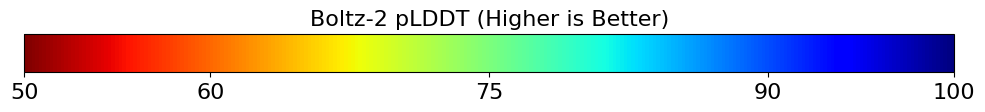

Design Rank 02, ligand_plddt=92.78 /content/lasermpnn_outputs_r2/00063_laser_model_0/design_3.pdb /content/boltz_results_boltz_inputs_laser_outputs_r2/predictions/00063_laser_model_0_design_2/00063_laser_model_0_design_2_model_0.cif


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

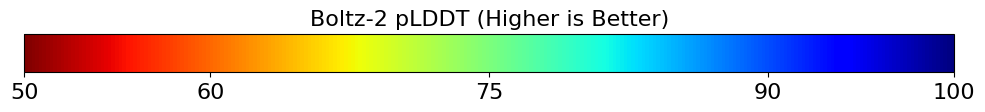

Design Rank 03, ligand_plddt=90.35 /content/lasermpnn_outputs_r2/00086_laser_model_0/design_3.pdb /content/boltz_results_boltz_inputs_laser_outputs_r2/predictions/00086_laser_model_0_design_4/00086_laser_model_0_design_4_model_0.cif


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

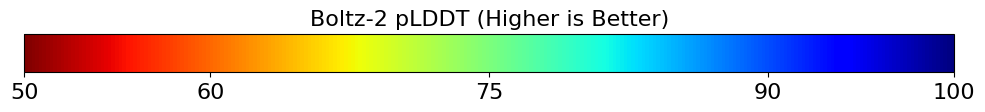

Design Rank 04, ligand_plddt=82.08 /content/lasermpnn_outputs_r2/00061_laser_model_0/design_3.pdb /content/boltz_results_boltz_inputs_laser_outputs_r2/predictions/00061_laser_model_0_design_0/00061_laser_model_0_design_0_model_0.cif


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

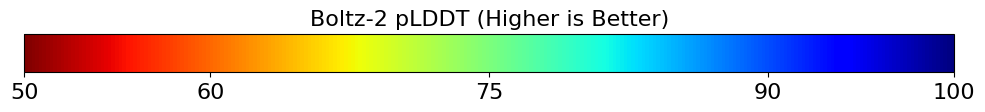

Design Rank 05, ligand_plddt=80.75 /content/lasermpnn_outputs_r2/00013_laser_model_0/design_3.pdb /content/boltz_results_boltz_inputs_laser_outputs_r2/predictions/00013_laser_model_0_design_4/00013_laser_model_0_design_4_model_0.cif


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

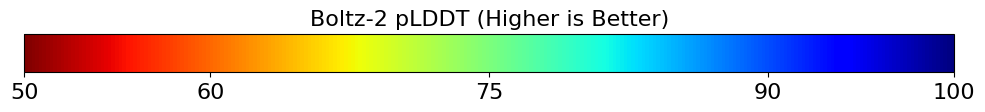

In [11]:
# @title Visualize top designs.
import py3Dmol
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import shutil
from google.colab import files
from datetime import datetime


now = datetime.now()
timestamp = int(now.timestamp())
zip_output = f'carpdock_results-{timestamp}.zip'

for idx, (i,j) in enumerate(reversed(sorted(original_laser_path_to_confidence.items(), key=lambda x: x[1]))):
  print(f'Design Rank {(idx + 1):02d}, ligand_plddt={j:.2f}', i, original_laser_path_to_top_design[i])
  protein = pr.parseMMCIF(original_laser_path_to_top_design[i])
  pr.writePDB(str(original_laser_path_to_top_design[i].with_suffix('.pdb').absolute()), protein)

  view = py3Dmol.view(width=1000)
  view.addModel(open(original_laser_path_to_top_design[i].with_suffix('.pdb'), 'r').read(),'pdb', keepH=True)
  view.setStyle({
    'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':100}},
    'stick': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':100}}
  })
  view.setBackgroundColor('black')
  view.zoomTo()
  view.show()

  cmap = mpl.cm.jet_r
  fig, ax = plt.subplots(figsize=(12, 0.5))
  norm = mpl.colors.Normalize(vmin=50, vmax=100)
  cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
  ticks = [50, 60, 75, 90, 100]
  cbar.set_ticks(ticks)
  cbar.set_ticklabels(ticks, fontsize=16)
  plt.title("Boltz-2 pLDDT (Higher is Better)", fontsize=16)
  plt.show()
  plt.close()


  top_carpdock_output = i
  top_round1_nise_output = original_laser_path_to_top_design[i]

  shutil.copy(top_carpdock_output, f'rank_{idx:02d}_top_carpdock_output.pdb')
  shutil.copy(top_round1_nise_output.with_suffix('.pdb'), f'rank_{idx:02d}_top_round1_nise_output.pdb')

  subprocess.run(f"python /content/NISE/protonate_and_add_conect_records.py rank_{idx:02d}_top_carpdock_output.pdb '{protonated_smiles}' rank_{idx:02d}_top_carpdock_output_H.pdb", shell=True)
  subprocess.run(f"python /content/NISE/protonate_and_add_conect_records.py rank_{idx:02d}_top_round1_nise_output.pdb '{protonated_smiles}' rank_{idx:02d}_top_round1_nise_output_H.pdb", shell=True)

  subprocess.run(f'zip -j {zip_output} rank_{idx:02d}_top_carpdock_output_H.pdb rank_{idx:02d}_top_round1_nise_output_H.pdb', shell=True)



In [12]:
# @title ### Download the results.

# @markdown The next steps of the design pipeline would be to input the top poses into the NISE protocol. However, the NISE protocol typically needs to run for 1 or more days with multiple gpus if possible which makes it difficult to run in Colab. It may be possible to implement a simplified version of NISE for Colab but currently there aren't any notebooks to do this. You could take the code block above and modify it to take the most confident designs (by ligand plddt, iptm or a sum of both) that come out of the 1 round that we just ran to start more rounds of optimization. Around 10-20 rounds would likely be sufficient.


# @markdown A note on ligand RMSD filtering:
# @markdown When generating the ligand poses with CARPdock, it doesn't really matter what the ligand RMSDs are since we ultimately just want something that can be predictdd with high confidence. I've computed the ligand RMSDs for you here, but only used very loose RMSD thresholds. Ultimately you just a structure that lasermpnn generates sequences which can be predicted with low ligand RMSD before beginning the NISE protocol.


# @markdown Before putting the outputs of this notebook through further rounds of design and optimization, check them for atom clashing, stereochemistry violations, etc... that would prevent your design from working experimentally.
download_zipped_results = True # @param {"type":"boolean","placeholder":"True"}

if download_zipped_results:
  files.download(zip_output)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>